# Neutrino decay: 2 & 3 flavors, degenerate/hierarchical masses.

In [1]:
from project_imports_2.shared import *
from project_imports_2.shared_functions import *
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *
from Shared.specific_CNB_decay import *

################
### Controls ###
################
P_NR = 100
G_NR = 100
Z_NR = 50
INT_STEPS_2FLAVOR = 100
INT_STEPS_3FLAVOR = 50

#########################
### Special Functions ###
#########################
def SPEC_n_prefactor(p, z):
    return p**2/(2*np.pi**2*(1+z)**3) * 1/(np.exp(p/(T_CNB*(1.+z))) + 1)

fig_dir = 'figures/project_neutrino_decay'

ModuleNotFoundError: No module named 'pynverse'

## Simple decay expression: Number density today, with and without decay, comoving number density.

Number density today with no decay: 55.83483319968792 1/cm^3
55.83483319968804


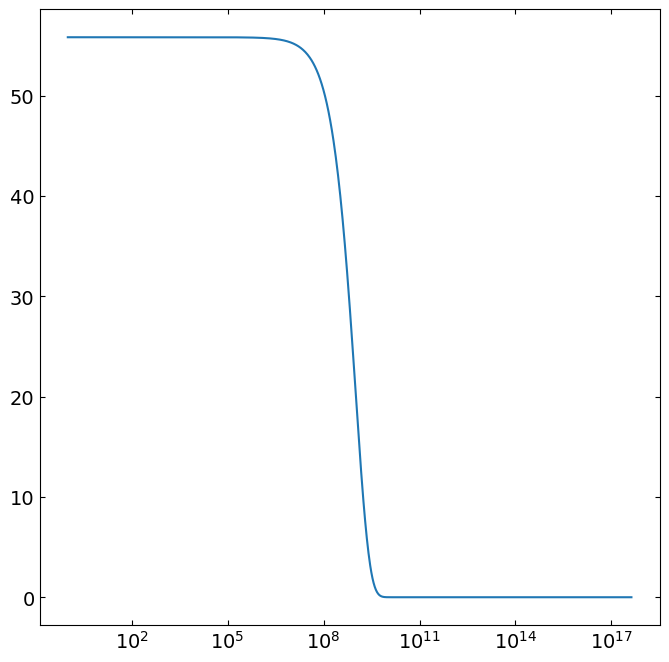

55.83446403013704


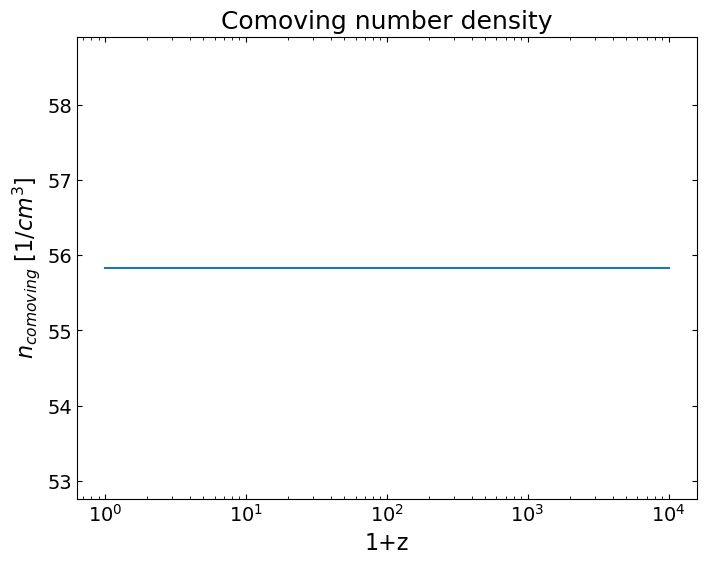

In [3]:
def n_integrand_noDecay(p):
    return p**2 / (2*np.pi**2) * 1/(np.exp(p/T_CNB)+1)

p_range = np.linspace(0, 10, 10000)*T_CNB
n0_noDecay = np.trapz(n_integrand_noDecay(p_range), p_range)
print(f'Number density today with no decay: {n0_noDecay/(1./cm**3)} 1/cm^3')


def n_integrand_decay(p, t, Gamma, m):
    
    t_nu = 1.*s
    n_0 = p**2 / (2*np.pi**2) * 1/(np.exp(p/T_CNB)+1)
    exp_time = np.exp(-Gamma * (m/np.sqrt(p**2+m**2)) * (t-t_nu))

    return n_0 * exp_time


t_today = 13.8 * 1e9 * (356*24*60*60)
t_range = np.logspace(np.log10(1), np.log10(t_today), num = 1000) *s
Gamma, m = 10.e-10/s, 1.*eV 

# Reshape momentum array to (X,1), where X is the length of the original array.
p_range = p_range.reshape(-1,1)
n0_decay = np.trapz(
    n_integrand_decay(p_range, t_range, Gamma, m), 
    x=p_range, axis=0
)

n0_plot = np.array(n0_decay)/(1./cm**3)
print(n0_plot[0])

plt.semilogx(t_range/s, n0_plot)
plt.show()


### Comoving Number Density
# Redshift range.
z_0, z_dec = 0., 10000.
z_range = np.logspace(np.log10(z_0+1), np.log10(z_dec+1), Z_NR)-1

com_n = np.zeros(len(z_range))
for i, z in enumerate(z_range):
    p_range = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z)
    
    n_raw = SPEC_n_prefactor(p=p_range, z=z)
    com_n[i] = np.trapz(n_raw, p_range)


# Print & plot results.
print(np.mean(com_n)/(1/cm**3))
plt.figure(figsize=(8, 6))
plt.semilogx(1+z_range, com_n/(1/cm**3))
plt.title('Comoving number density')
plt.xlabel('1+z')
plt.ylabel(r'$n_{comoving}$ [$1/cm^3$]')
plt.show()

## 2 Flavor - Quasidegenerate (QD) masses.

In [6]:
def Xi(z_end, z, p, m, int_steps=INT_STEPS_2FLAVOR):
    """Auxiliary integral, representing effective time between z_end and z."""

    # Integrand in xi function
    def integrand(z, p, m):
        return 1/(CALC_Hubble_rate(z)*(1+z)) * 1/(np.sqrt( (1+z)**2 + (m**2/p**2) ))

    # Create redshift integration range.
    z_int_range = np.logspace(np.log10(z+1), np.log10(z_end+1), int_steps)-1

    # Reshape momentum array.
    if isinstance(p, np.ndarray):
        p = p.reshape(-1,1)

    # Array to integrate over
    int_array = integrand(z_int_range, p, m)

    # Integrated array
    Xi_array = np.trapz(int_array, x=z_int_range, axis=1)

    return Xi_array


def n3_p_range(p, z, z_end, Gamma, m):
    """Number density for m_3 per momentum range."""

    # Prefactor
    n_pre = SPEC_n_prefactor(p,z)

    # Exp-factor with Xi integral.
    Xi_factor = Xi(z_end, z, p/(1+z), m)
    n_exp = np.exp(-(m*Gamma*(1+z))/p * Xi_factor)

    return n_pre * n_exp


def n1_p_range(p, z, z_end, Gamma, m, int_steps=INT_STEPS_2FLAVOR):
    """Number density for m_1 per momentum range."""

    # Prefactor
    n_pre = SPEC_n_prefactor(p,z)

    def n3_integrand(p, z, z_int):

        # Prefactor with Hubble const.
        pre = 1/(CALC_Hubble_rate(z_int)*(1+z_int))

        # Exponential term with xi integral.
        Xi_factor = Xi(z_end, z_int, p/(1+z), m)
        exp = np.exp(-(m*Gamma*(1+z))/p * Xi_factor)

        # Decay const. term.
        a_31 = Gamma * m / np.sqrt((p**2 * (1+z_int)**2 / (1+z)**2) + m**2)

        return pre*exp*a_31

    # Evaluate outer integral from z to z_end.
    z_int_range = np.logspace(np.log10(z+1), np.log10(z_end+1), int_steps)-1
    n3_vals = []
    for z_int in z_int_range:
        n3_vals.append(n3_integrand(p, z, z_int))

    n3s = np.trapz(np.array(n3_vals), z_int_range, axis=0)

    return n_pre * (1 + n3s)

### n1 & n3 redshift evolution AND n_e evolution

n1 today : 81.93231124627694
n1 at dec : 58.839914839588644


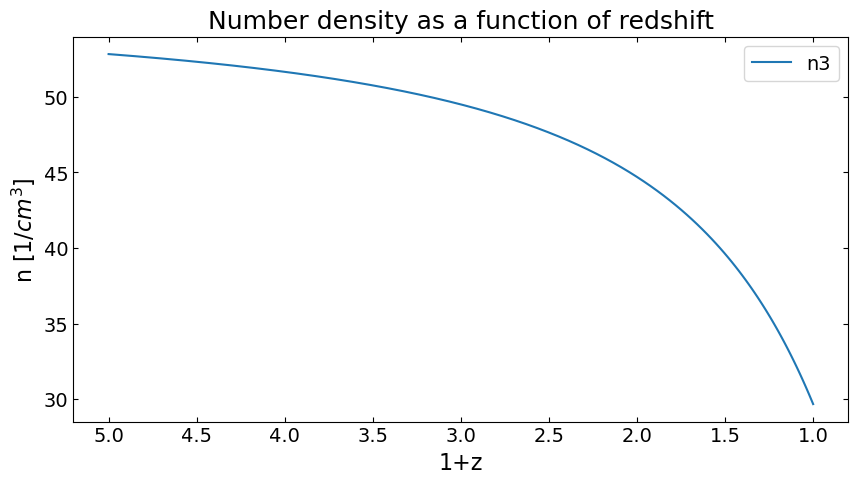

In [16]:
# Redshift range
#z_0, z_dec = 1e0, 1e4
#z_range = np.logspace(np.log10(z_0+1), np.log10(z_dec+1), Z_NR)-1
Gamma_val = (1/(2*Params.t0/s))/s
z_range =  np.array([0, 0.0038223239895366357, 0.007790749585883147, 0.011910861265805747, 0.016188456962865708, 0.02062955622642977, 0.02524040869254421, 0.03002750287859307, 0.03499757531411696, 0.040157620020641244, 0.04551489835385383, 0.05107694922198308, 0.056851599694755006, 0.0628469760178596, 0.06907151504842529, 0.07553397612759427, 0.08224345340690684, 0.08920938864583905, 0.09644158449850457, 0.10395021830821685, 0.11174585642932416, 0.11983946909647203, 0.12824244586221653, 0.1369666116247132, 0.14602424326803673, 0.1554280869385469, 0.16519137598161346, 0.175327849563941, 0.1858517720076989, 0.19677795286366476, 0.2081217677516284, 0.21989917999738326, 0.23212676309675426, 0.244821724038273, 0.25800192751732176, 0.27168592107582, 0.28589296120283125, 0.3006430404328204, 0.3159569154796932, 0.33185613644621015, 0.3483630771498797, 0.36550096660800413, 0.3832939217261868, 0.4017669812362995, 0.4209461409316684, 0.4408583902490648, 0.46153175024897664, 0.48299531304760823, 0.5052792827561012, 0.528415017984583, 0.5524350759708586, 0.5773732583958445, 0.6032646589502149, 0.630145712719202, 0.6580542474550415, 0.687029536809217, 0.7171123555994148, 0.7483450371889591, 0.7807715330594762, 0.8144374746606183, 0.8493902376238842, 0.8856790084309009, 0.9233548536299822, 0.9624707916983682, 1.0030818676512752, 1.0452452305027389, 1.0890202136872689, 1.1344684185554774, 1.1816538010611768, 1.2306427617619466, 1.2815042392598066, 1.3343098072134996, 1.3891337750588981, 1.4460532925792675, 1.5051484584725454, 1.5665024330684194, 1.6302015553538058, 1.69633546447143, 1.7649972258624762, 1.83628346223081, 1.9102944895130896, 1.9871344580460817, 2.066911499129862, 2.1497378771931315, 2.235730147774776, 2.3250093215440115, 2.417701034589889, 2.5139357252198296, 2.613848817515976, 2.7175809119076466, 2.825277983028097, 2.937091585134014, 3.0531790653767907, 3.173703785225734, 3.2988353503547874, 3.4287498493162487, 3.5636301013374028, 3.7036659135887087, 3.849054348285637, 3.9999999999999996])
p_range =   np.linspace(0.01, 400, 10000) * T_CNB 

# n1 and n3 number density
n1s = np.zeros(len(z_range))
n3s = np.zeros(len(z_range))
for i, z in enumerate(z_range):
    p_range = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z)
   
    n1_raw = n1_p_range(p=p_range, z=z, z_end=z_dec, Gamma=Gamma_val, m=0.05*eV)
    n1s[i] = np.trapz(n1_raw, p_range)

    n3_raw = n3_p_range(p=p_range, z=z, z_end=z_dec, Gamma=Gamma_val, m=0.06*eV)
    n3s[i] = np.trapz(n3_raw, p_range)


# Print & plot results.
print('n1 today :', np.max(n1s)/(1/cm**3))
print('n1 at dec :', np.min(n1s)/(1/cm**3))
fig, ax = plt.subplots(figsize=(10,5))
#ax.semilogx(1+z_range, n3s/(1/cm**3), label='n3')
ax.plot(1+z_range, n3s/(1/cm**3), label='n3')
#ax.semilogx(1+z_range, n1s/(1/cm**3), label='n1')
ax.set_xlabel('1+z')

plt.title("Number density as a function of redshift")
ax.invert_xaxis()
ax.set_ylabel(r'n [$1/cm^3$]')
plt.legend()
plt.show()


### Electron number densities

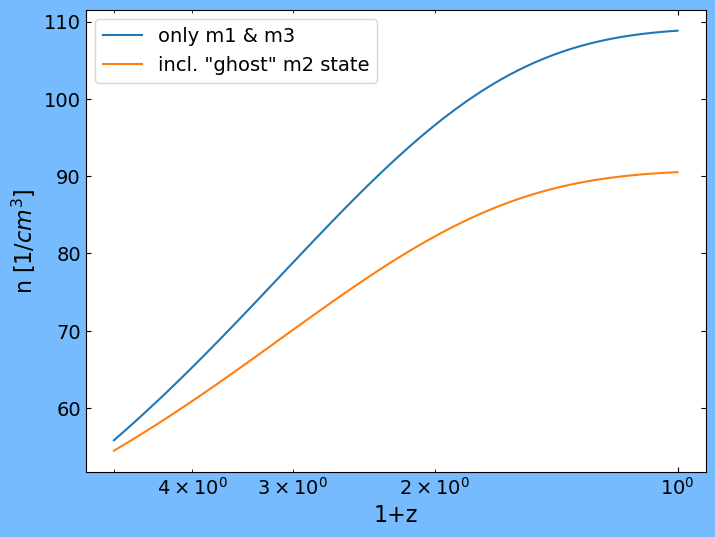

max of n_e : 108.8171645502841
max of n_e_3 : 90.51703534877541


In [43]:
# Mixing angle.
theta = np.deg2rad(8.57)

# Electron number density.
n_e = (np.sin(theta)**2 * n3s) + (np.cos(theta)**2 * n1s)

# Ghost m2 eigenstate, const. density over z.
n2s = np.min(n1s)*np.ones(len(n1s))

# Electron number density with 3 flavors
U_e1, U_e2, U_e3 = 0.82, 0.53, 0.15
n_e_3 = (U_e1**2 * n1s) + (U_e2**2 * n2s) + (U_e3**2 * n3s)


fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_facecolor('xkcd:sky blue')
ax.semilogx(1+z_range, n_e/(1/cm**3), label='only m1 & m3')
ax.semilogx(1+z_range, n_e_3/(1/cm**3), label='incl. "ghost" m2 state')
ax.set_xlabel('1+z')
ax.invert_xaxis()
ax.set_ylabel(r'n [$1/cm^3$]')
plt.legend()
plt.show()
print('max of n_e :', np.max(n_e*cm**3))
print('max of n_e_3 :', np.max(n_e_3*cm**3))

### xi integral plot

(50, 100)


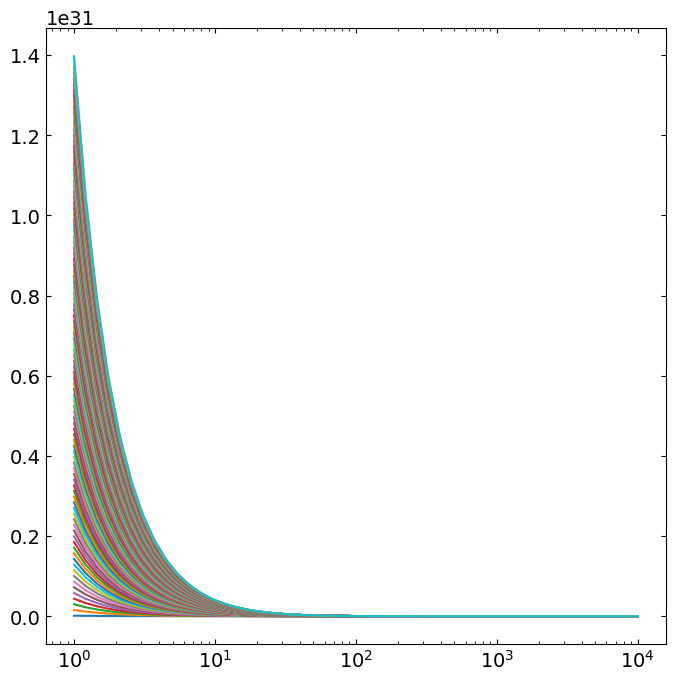

In [44]:
z_0, z_dec = 0., 10000.
z_xi = np.logspace(np.log10(z_0+1), np.log10(z_dec+1), Z_NR)-1
p_xi = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z_0)
# p_xi = 3.15*T_CNB


xis = np.array([Xi(z_end=z_dec, z=z, p=p_xi, m=0.1*eV) for z in z_xi])
print(xis.shape)

plt.semilogx(1+z_xi, xis)
plt.show()

### Momentum distr. for n3 and n1 today (z=0).

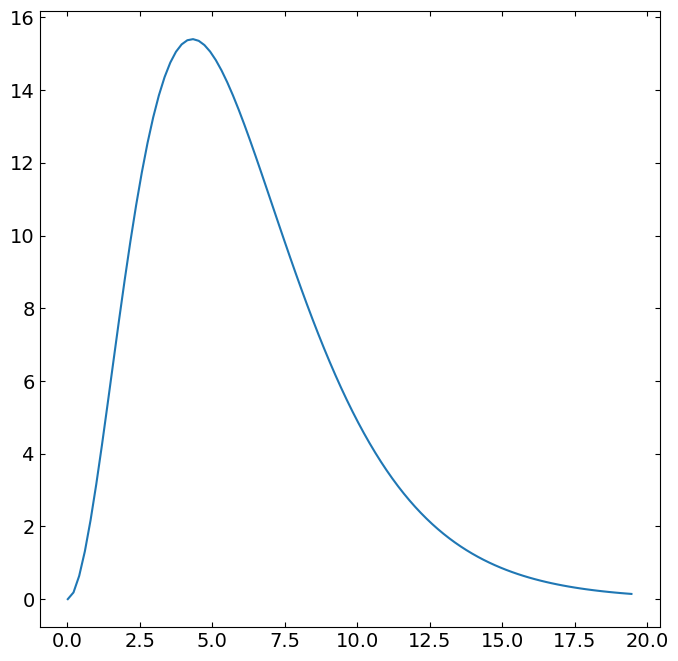

n1 : 111.55028086403429


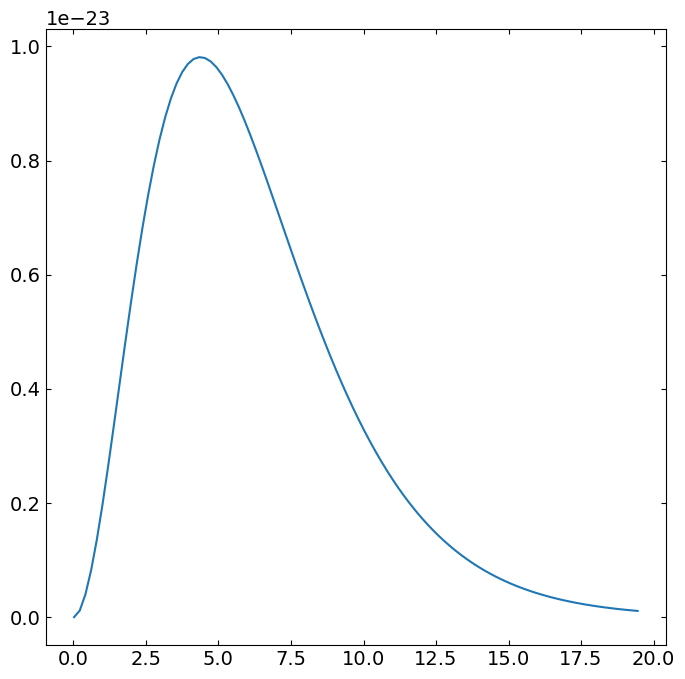

n3 : 7.234348934200386e-23


In [45]:
z_0, z_dec = 0., 10000.
p_range = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z_0)

n1s_per_p = n1_p_range(p=p_range, z=z_0, z_end=z_dec, Gamma=1e-16/s, m=0.1*eV)

plt.plot(p_range/K, n1s_per_p/(1/cm**3/K))
plt.show()

n1_today = np.trapz(n1s_per_p, p_range)
print('n1 :', n1_today/(1/cm**3))

n3s_per_p = n3_p_range(p=p_range, z=z_0, z_end=z_dec, Gamma=1e-16/s, m=0.1*eV)

plt.plot(p_range/K, n3s_per_p/(1/cm**3/K))
plt.show()

n3_today = np.trapz(n3s_per_p, p_range)
print('n3 :', n3_today/(1/cm**3))

### Dependence of n1 & n3 today (z=0) on Gamma

Age of universe in seconds : 4.24E+17


FileNotFoundError: [Errno 2] No such file or directory: 'figures/project_neutrino_decay/tau_dependence_2_flavor.png'

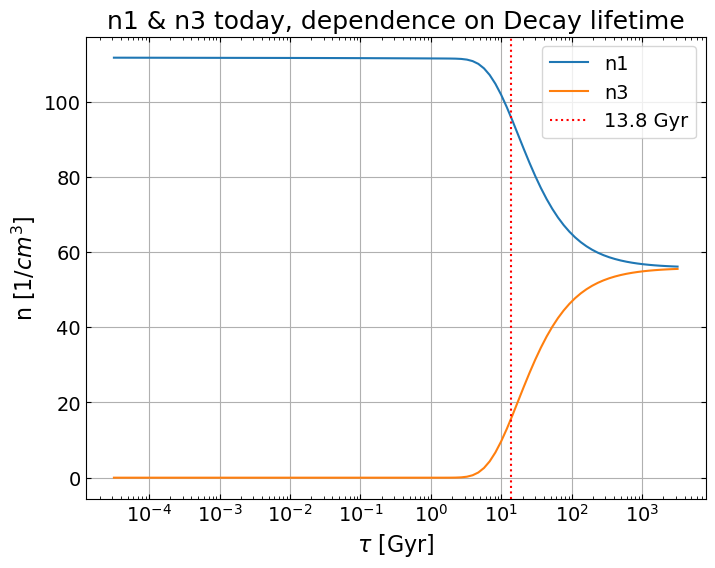

In [46]:
# Redshift values.
z_0, z_dec = 0., 10000.
p_range = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z_0)
Gamma_range = np.logspace(-20, -12, G_NR)/s

# n1 number density
n1s = np.zeros(len(Gamma_range))
for i, G in enumerate(Gamma_range):
    n1_raw = n1_p_range(p=p_range, z=z_0, z_end=z_dec, Gamma=G, m=0.1*eV)
    n1s[i] = np.trapz(n1_raw, p_range)

# n3 number density
n3s = np.zeros(len(Gamma_range))
for i, G in enumerate(Gamma_range):
    n3_raw = n3_p_range(p=p_range, z=z_0, z_end=z_dec, Gamma=G, m=0.1*eV)
    n3s[i] = np.trapz(n3_raw, p_range)

print('Age of universe in seconds :', f'{13.8e9*(356*24*60*60):.2E}')
plt.figure(figsize=(8, 6))
Gyr = 1e9*365*24*60*60*s
tU = 13.8*Gyr
plt.semilogx(1/Gamma_range/(Gyr), n1s/(1/cm**3), label='n1')
plt.semilogx(1/Gamma_range/(Gyr), n3s/(1/cm**3), label='n3')
plt.axvline(13.8, c='r', ls=':', label='13.8 Gyr')
plt.title('n1 & n3 today, dependence on Decay lifetime')
plt.xlabel(r'$\tau$ [Gyr]')
plt.ylabel(r'n [$1/cm^3$]')
plt.grid(True)
plt.legend()
plt.savefig(f'{fig_dir}/tau_dependence_2_flavor.png', dpi=300)
plt.show()

## 3 Flavor - QD masses.

In [ ]:
def Xi(z_end, z, p, m, int_steps=INT_STEPS_3FLAVOR):

    # Integrand in xi function
    def integrand(z, p, m):
        return 1/(CALC_Hubble_rate(z)*(1+z)) * 1/(np.sqrt( (1+z)**2 + (m**2/p**2) ))

    # Create redshift integration range.
    z_int_range = np.logspace(np.log10(z+1), np.log10(z_end+1), int_steps)-1

    # Reshape momentum array.
    if isinstance(p, np.ndarray):
        p = p.reshape(-1,1)

    # Array to integrate over
    int_array = integrand(z_int_range, p, m)

    # Integrated array
    Xi_array = np.trapz(int_array, x=z_int_range, axis=1)

    return Xi_array



def n3_p_range(p, z, z_end, Gamma, m):
    """Number density for m_3 per momentum range."""

    # Prefactor
    n_pre = SPEC_n_prefactor(p,z)

    # Exp-factor with Xi integral.
    Xi_factor = Xi(z_end, z, p/(1+z), m)
    n_exp = np.exp(-(m*Gamma*(1+z))/p * Xi_factor)

    return n_pre * n_exp



def n2_p_range(p, z, z_end, Gamma, m, int_steps=INT_STEPS_3FLAVOR):
    """Number density for m_2 per momentum range."""

    # Prefactor
    n_pre = SPEC_n_prefactor(p,z)

    # Exponential term outside integral.
    Xi_outer = Xi(z_end, z, p/(1+z), m)
    outer_exp = np.exp(-(m*Gamma*(1+z))/p * Xi_outer)

    def n2_integrand(p, z, z_int):

        # Prefactor with Hubble const.
        pre = 1/(CALC_Hubble_rate(z_int)*(1+z_int))

        # Exponential factor with Gamma_32.
        Xi_32 = Xi(z_end, z_int, p/(1+z), m)
        exp_32 = np.exp(-(m*Gamma*(1+z))/p * Xi_32)

        # Exponential factor with Gamma_21.
        Xi_21 = Xi(z_int, z, p/(1+z), m)
        exp_21 = np.exp(-(m*Gamma*(1+z))/p * Xi_21)

        # Decay const. term.
        a_32 = Gamma * m / np.sqrt((p**2 * (1+z_int)**2 / (1+z)**2) + m**2)

        return pre*exp_32*exp_21*a_32


    # Evaluate outer integral from z to z_end.
    z_int_range = np.logspace(np.log10(z+1), np.log10(z_end+1), int_steps)-1
    n2_vals = []
    for z_int in z_int_range:
        n2_vals.append(n2_integrand(p, z, z_int))

    n2s = np.trapz(np.array(n2_vals), z_int_range, axis=0)

    return n_pre * (outer_exp + n2s) 



def n1_p_range(p, z, z_end, Gamma, m, int_steps=INT_STEPS_3FLAVOR):

    # Prefactor
    n_pre = SPEC_n_prefactor(p,z)

    def inner_int(p, z_inner, z_prime, z_dprime, z_end_inner):

        # Prefactor with Hubble const.
        pre_inner = 1/(CALC_Hubble_rate(z_dprime)*(1+z_dprime))

        # Exponential factor with Gamma_32 in inner integral.
        Xi_32_inner = Xi(z_end_inner, z_dprime, p/(1+z_inner), m)
        exp_32_inner = np.exp(-(m*Gamma*(1+z_inner))/p * Xi_32_inner)

        # Exponential factor with Gamma_21 in inner integral.
        Xi_21_inner = Xi(z_dprime, z_prime, p/(1+z_inner), m)
        exp_21_inner = np.exp(-(m*Gamma*(1+z))/p * Xi_21_inner)

        # Decay const. term in inner integral.
        a_32 = Gamma*m/np.sqrt((p**2*(1+z_dprime)**2/(1+z_inner)**2)+m**2)

        return pre_inner*exp_32_inner*exp_21_inner*a_32


    def outer_int(p, z_outer, z_prime_outer, z_end_outer, int_steps_inner):

        # Prefactor with Hubble const.
        pre_outer = 1/(CALC_Hubble_rate(z_prime_outer)*(1+z_prime_outer))

        # Exponential factor with Gamma_31 in outer integral.
        Xi_31_outer = Xi(z_end_outer, z_prime_outer, p/(1+z_outer), m)
        exp_31_outer = np.exp(-(m*Gamma*(1+z_outer))/p * Xi_31_outer)

        # Exponential factor with Gamma_21 in outer integral.
        Xi_21_outer = Xi(z_end_outer, z_prime_outer, p/(1+z_outer), m)
        exp_21_outer = np.exp(-(m*Gamma*(1+z_outer))/p * Xi_21_outer)

        # Decay const. terms in outer integral.
        a_31 = Gamma*m/np.sqrt((p**2*(1+z_prime_outer)**2/(1+z_outer)**2)+m**2)
        a_21 = Gamma*m/np.sqrt((p**2*(1+z_prime_outer)**2/(1+z_outer)**2)+m**2)


        # Evaluate inner integral from z_prime_outer to z_end_outer.
        z_int_inner_range = np.logspace(np.log10(z_prime_outer+1), np.log10(z_end_outer+1), int_steps_inner)-1
        n1_inner_vals = []
        for z_int in z_int_inner_range:
            n1_inner_vals.append(inner_int(p, z_outer, z_prime_outer, z_int, z_end_outer))

        n1s_inner = np.trapz(np.array(n1_inner_vals), z_int_inner_range, axis=0)


        # with_m31 = pre_outer*((exp_31_outer*a_31) + (a_21*(exp_21_outer + n1s_inner)))
        without_m31 = pre_outer*a_21*(exp_21_outer + n1s_inner)


        return without_m31


    # Evaluate outer integral from z to z_end
    z_int_outer_range = np.logspace(np.log10(z+1), np.log10(z_end+1), int_steps)-1

    n1_outer_vals = []
    for z_int in z_int_outer_range:
        n1_outer_vals.append(outer_int(p, z, z_int, z_end, int_steps))

    n1s_outer = np.trapz(np.array(n1_outer_vals), z_int_outer_range, axis=0)


    return n_pre*(1+n1s_outer)

### n3 & n2 & n1 redshift evolution

In [ ]:
# Redshift range.
z_0, z_dec = 0., 10000.
z_range = np.logspace(np.log10(z_0+1), np.log10(z_dec+1), Z_NR)-1
Gamma_in = 1e-16/s
m_in = 0.1*eV

# n1 number density
n1s = np.zeros(len(z_range))
for i, z in enumerate(z_range):
    p_range = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z)
    n1_raw = n1_p_range(p=p_range, z=z, z_end=z_dec, Gamma=Gamma_in, m=m_in)
    n1s[i] = np.trapz(n1_raw, p_range)

# n2 number density
n2s = np.zeros(len(z_range))
for i, z in enumerate(z_range):
    p_range = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z)
    n2_raw = n2_p_range(p=p_range, z=z, z_end=z_dec, Gamma=Gamma_in, m=m_in)
    n2s[i] = np.trapz(n2_raw, p_range)

# n3 number density
n3s = np.zeros(len(z_range))
for i, z in enumerate(z_range):
    p_range = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z)
    n3_raw = n3_p_range(p=p_range, z=z, z_end=z_dec, Gamma=Gamma_in, m=m_in)
    n3s[i] = np.trapz(n3_raw, p_range)

n1 today : 167.3150542082107
n1 at dec : 55.83446403013703


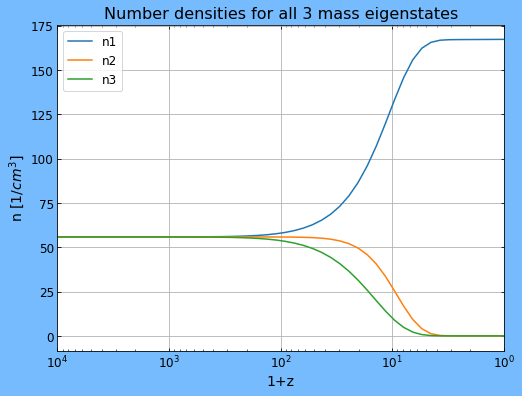

In [ ]:
# Print & plot results.
print('n1 today :', np.max(n1s)/(1/cm**3))
print('n1 at dec :', np.min(n1s)/(1/cm**3))
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_facecolor('xkcd:sky blue')
ax.semilogx(1+z_range, n1s/(1/cm**3), label='n1')
ax.semilogx(1+z_range, n2s/(1/cm**3), label='n2')
ax.semilogx(1+z_range, n3s/(1/cm**3), label='n3')
ax.set_title('Number densities for all 3 mass eigenstates')
ax.set_xlabel('1+z')
ax.invert_xaxis()
ax.set_xlim(1e4, 1e0)
ax.set_ylabel(r'n [$1/cm^3$]')
ax.legend()
ax.grid(True)
plt.savefig(f'{fig_dir}/number_densities_3_flavor.png', dpi=300)
plt.show()

### Electron number density

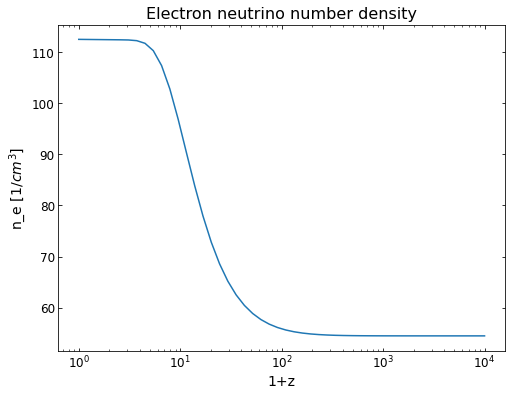

max of n_e_3 : 112.50264244960086
0.82**2*max(n1s) : 112.50264244960086


In [ ]:
# Electron number density with 3 flavors
U_e1, U_e2, U_e3 = 0.82, 0.53, 0.15
n_e_3 = (U_e1**2 * n1s) + (U_e2**2 * n2s) + (U_e3**2 * n3s)

plt.figure(figsize=(8, 6))
plt.semilogx(1+z_range, n_e_3/(1/cm**3))
plt.title('Electron neutrino number density')
plt.xlabel('1+z')
plt.ylabel(r'n_e [$1/cm^3$]')
plt.show()
print('max of n_e_3 :', np.max(n_e_3)*cm**3)
print('0.82**2*max(n1s) :', 0.82**2*np.max(n1s)*cm**3)

### Dependence of n1 & n2 & n3 today (z=0) on Gamma

In [ ]:
# Redshift values.
z_0, z_dec = 0., 10000.
p_range = np.linspace(0.01, 10, P_NR)*T_CNB*(1+z_0)
Gamma_range = np.logspace(-20, -12, G_NR)/s
m_in = 0.1*eV

# n1 number density
n1s = np.zeros(len(Gamma_range))
for i, G in enumerate(Gamma_range):
    n1_raw = n1_p_range(p=p_range, z=z_0, z_end=z_dec, Gamma=G, m=m_in)
    n1s[i] = np.trapz(n1_raw, p_range)

# n2 number density
n2s = np.zeros(len(Gamma_range))
for i, G in enumerate(Gamma_range):
    n2_raw = n2_p_range(p=p_range, z=z_0, z_end=z_dec, Gamma=G, m=m_in)
    n2s[i] = np.trapz(n2_raw, p_range)

# n3 number density
n3s = np.zeros(len(Gamma_range))
for i, G in enumerate(Gamma_range):
    n3_raw = n3_p_range(p=p_range, z=z_0, z_end=z_dec, Gamma=G, m=m_in)
    n3s[i] = np.trapz(n3_raw, p_range)

Age of universe in seconds : 4.24E+17


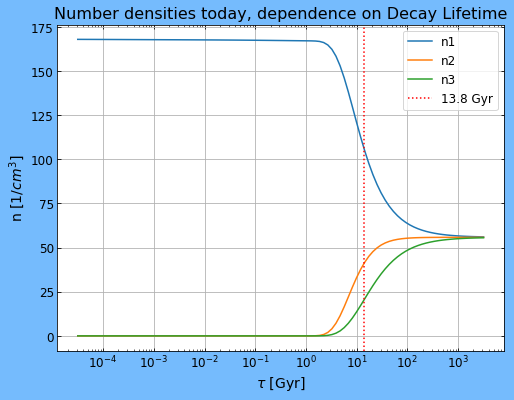

In [ ]:
print('Age of universe in seconds :', f'{13.8e9*(356*24*60*60):.2E}')
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('xkcd:sky blue')
Gyr = 1e9*365*24*60*60*s
tU = 13.8*Gyr
plt.semilogx(1/Gamma_range/(Gyr), n1s/(1/cm**3), label='n1')
plt.semilogx(1/Gamma_range/(Gyr), n2s/(1/cm**3), label='n2')
plt.semilogx(1/Gamma_range/(Gyr), n3s/(1/cm**3), label='n3')
plt.axvline(13.8, c='r', ls=':', label='13.8 Gyr')
plt.title('Number densities today, dependence on Decay Lifetime')
plt.xlabel(r'$\tau$ [Gyr]')
plt.ylabel(r'n [$1/cm^3$]')
plt.legend()
plt.grid(True)
plt.savefig(f'{fig_dir}/tau_dependence_3_flavor.png', dpi=300)
plt.show()